# Visualicemos nuestro modelo

Ya que comprendimos el problema de asociaciones falsas, y en el trayecto desarrollamos un modelo multivariable conviene entender un par de maneras de visualizar nuestro modelo.

Visualizar modelos de regresión sobre dos variables es fácil. Con una gráfica de dispersión de puntos basta. Sin embargo, conforme el modelo crece en variables, se vuelve más y más complejo visualizar. Acá veremos un par de ideas.

> **Objetivos:**
> - Generar visualizaciones para entender un modelo multivariable.


> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

Cosas que ya vimos y reutilizaremos:

In [1]:
# Import pandas
import pandas as pd
import numpy as np

import arviz as az
import pymc as pm

from causalgraphicalmodels import CausalGraphicalModel
from daft import PGM

from matplotlib import pyplot as plt

/home/esteban/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read WaffleDivorce data
divorce_data = pd.read_csv(
    "data/WaffleDivorce.csv",
    low_memory=False,
    sep=";"
)
divorce_data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [3]:
# Standardize function
def standardize(y: pd.Series) -> pd.Series:
    return (y - y.mean()) / y.std()

In [4]:
# Standardize variables
divorce_data["DivorceStd"] = standardize(divorce_data["Divorce"])
divorce_data["MarriageStd"] = standardize(divorce_data["Marriage"])
divorce_data["MedAgeMarriageStd"] = standardize(divorce_data["MedianAgeMarriage"])

In [5]:
# Multivariate model
with pm.Model() as multivariate_model:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu",
        a + bM * divorce_data["MarriageStd"] + bA * divorce_data["MedAgeMarriageStd"]
    )
    divorce_rate_std = pm.Normal(
        "divorce_rate_std",
        mu=mu,
        sigma=sigma,
        observed=divorce_data["DivorceStd"]
    )
    prior_samples = pm.sample_prior_predictive()
    idata_multivariate = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
divorce_data.shape

(50, 16)

1. **Gráficas de predicción posterior.** Es una manera de visualizar las predicciones del modelo respecto a los datos observados.

   Es útil para observar dos cosas:
   - ¿Es buena la aproximación del modelo a la distribución posterior? Todos los modelos se equivocan. Estas equivocaciones pueden ser evaluadas más fácilmente comparando las predicciones del modelo respecto a los datos observados.
   - ¿Cómo son los fallos del modelo? Muchas veces nuestros modelos serán buenos prediciendo respecto a algunas cosas, pero malos respecto a otras. Tras una inspección individual en los casos donde el modelo "falla", podemos obtener ideas de como mejorarlo.

In [7]:
# Muestreo de la distribución predictiva posterior
with multivariate_model:
    post_pred_samples = pm.sample_posterior_predictive(
        idata_multivariate,
        var_names=["mu", "divorce_rate_std"]
    )

Sampling: [divorce_rate_std]


In [8]:
post_pred_samples

Inference data with groups:
	> posterior_predictive
	> observed_data

In [10]:
# Media de mu a través de chain, draw
mu_mean = (
    post_pred_samples
    .posterior_predictive["mu"]
    .mean(dim=["chain", "draw"])
)
# HDI de mu
mu_hdi = az.hdi(
    post_pred_samples.posterior_predictive["mu"],
    hdi_prob=0.89
)
# Media de la tasa de divorcio a través de chain, draw
divorce_mean = (
    post_pred_samples
    .posterior_predictive["divorce_rate_std"]
    .mean(dim=["chain", "draw"])
)
# HDI de la tasa de divorcio
divorce_hdi = az.hdi(
    post_pred_samples.posterior_predictive["divorce_rate_std"],
    hdi_prob=0.89
)

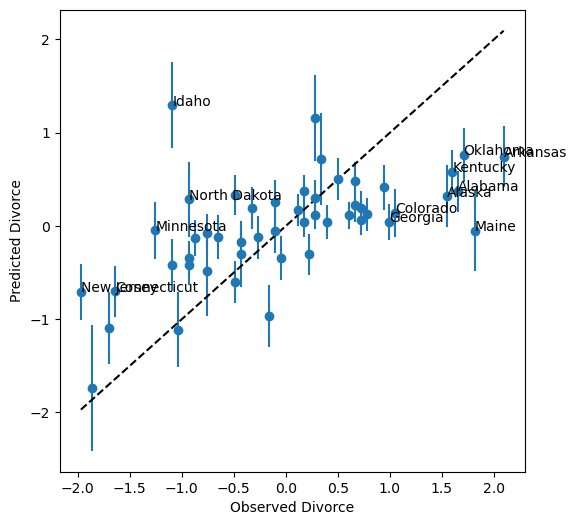

In [11]:
# Graficamos lo que piensa el modelo vs. la realidad
fig, ax = plt.subplots(figsize=(6, 6))
# Usamos barras de errores apra graficar intervalo
plt.errorbar(
    divorce_data["DivorceStd"].values,
    divorce_mean,
    yerr=np.abs(np.array(divorce_mean) - mu_hdi.min(dim="hdi").to_array()),
    fmt="C0o",
)
# Escribimos el estado en predicciones desfasadas
for i, err in enumerate(np.abs(divorce_data["DivorceStd"].values - divorce_mean)):
    if err > 0.9:
        plt.text(
            divorce_data["DivorceStd"].values[i],
            divorce_mean[i],
            divorce_data["Location"].values[i]
        )
 
min_x, max_x = divorce_data["DivorceStd"].min(), divorce_data["DivorceStd"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

Podemos observar que el modelo predice por debajo las tasas de divorcio de estados con altas tasas de divorcio, y similarmente predice por encima las tasas de divorcio de estados con bajas tasas de divorcio.

Esto es común en modelos de regresión. Los valores extremos son altamente penalizados.

Aún así, hay varios estados *muy lejos* de la diagonal.

2. **Gráficos contrafactuales.** Este tipo de gráfico inferencial muestra las implicaciones causales del modelo. Se llama contrafactual, dado que pueden ser producidos para cualesquiera valores de los predictores que se necesite, incluso combinaciones no observadas (p. e. un estado con una edad mediana alta al momento del matrimonio y una tasa de matrimonios alta).

   Por ejemplo, podríamos plantearnos la pregunta, ¿Cómo sería la tasa de divorcios de Utah si la tasa de matrimonios fuera mayor?. Esto no es posible verlo en la realidad, pero podemos entender como "piensa" nuestro modelo cuando intervenimos de manera artifical.

   De forma que, para generar gráficos contrafactuales:
   - Elegimos una variable para manipular: variable de intervención.
   - Definimos el rango de valores para manipular la variable de intervención.
   - Para cada valor de la variable de intervención, y para cada muestra en la posterior, usamos el modelo causal para simular valores de otras variables, incluyendo el resultado.

Para hacer esto en el modelo de divorcio, tomemos el siguiente grafo:

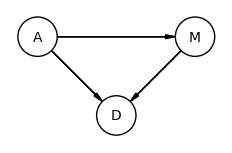

In [12]:
nodes = ["A", "D", "M"]
edges = [("A", "D"), ("A", "M"), ("M", "D")]
dag1 = CausalGraphicalModel(nodes=nodes, edges=edges)
pgm1 = PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in nodes:
    pgm1.add_node(node, node, *coordinates[node])
for edge in edges:
    pgm1.add_edge(*edge)
pgm1.render()
plt.gca().invert_yaxis()

Para esto, usaremos las mismas previas del modelo `marriage_model`. En este modelo, ignoramos la suposición de que $A$ influencia a $M$, dado que no la necesitábamos para estimar la influencia directa $A \rightarrow D$. Sin embargo, la necesitamos para predecir las consecuencias de manipular $A$, dado que algo del efecto de $A$ actúa a través de $M$.

In [13]:
# Importamos aesara.shared
from aesara import shared

In [14]:
# Usamos variables compartidas de aesara para cambiarlas luego
marriage_shared = shared(divorce_data["MarriageStd"].values)
age_shared = shared(divorce_data["MedAgeMarriageStd"].values)

In [15]:
# Multivariate model
with pm.Model() as multivariate_model_2:
    # A -> D <- M
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu",
        a + bM * marriage_shared + bA * age_shared
    )
    divorce_rate_std = pm.Normal(
        "divorce_rate_std",
        mu=mu,
        sigma=sigma,
        observed=divorce_data["DivorceStd"]
    )

    # A -> M
    sigmaM = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    muM = pm.Deterministic(
        "mu_m",
        aM + bAM * age_shared
    )
    marriage_rate_std = pm.Normal(
        "marriage_rate_std",
        muM,
        sigmaM,
        observed=divorce_data["MarriageStd"]
    )

    # Muestreo
    prior_samples = pm.sample_prior_predictive()
    idata_multivariate_2 = pm.sample()

Sampling: [a, aM, bA, bAM, bM, divorce_rate_std, marriage_rate_std, sigma, sigma_m]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, bA, sigma, sigma_m, bAM, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Variable de intervención y rango de valores. Recordemos que las variables están estandarizadas, por lo que estamos tomando $\pm 2$ desviaciones estándar lejos de la media.

In [16]:
# Usamos 50 para que sea igual a la dimensión de la entrada
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

Usamos el modelo causal para simular valores de otras variables, incluyendo el resultado:

In [17]:
# Simulamos la tasa de matrimonios para cada edad mediana
age_shared.set_value(A_seq)

with multivariate_model_2:
    pp_samples_marriage = pm.sample_posterior_predictive(idata_multivariate_2)

Sampling: [divorce_rate_std, marriage_rate_std]


Con esto, graficamos los gráficos contrafactuales. En el gráfico contrafactual de $D$, se incluyen ambos caminos $A \rightarrow D$ y $A \rightarrow M \rightarrow D$. Sabemos que la influencia $M \rightarrow D$ es pequeña, por lo que el segundo camino no contribuye mucho a la tendencia.

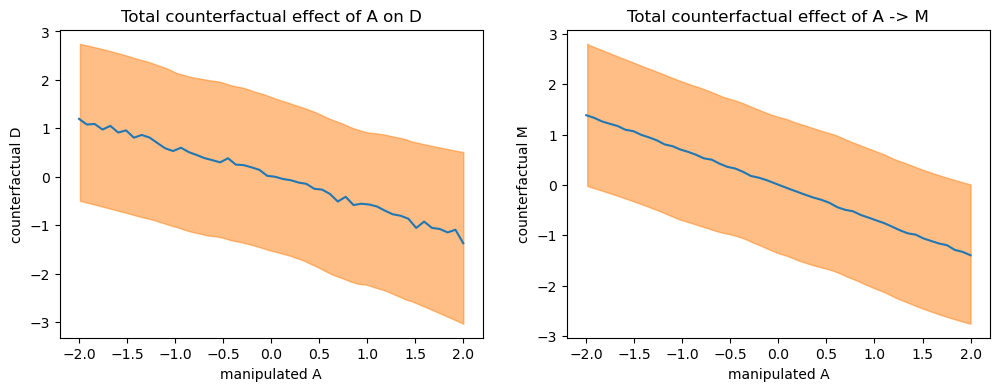

In [18]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, pp_samples_marriage.posterior_predictive["divorce_rate_std"], ax=ax[0])
ax[0].plot(A_seq, pp_samples_marriage.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, pp_samples_marriage.posterior_predictive["marriage_rate_std"], ax=ax[1])
ax[1].plot(A_seq, pp_samples_marriage.posterior_predictive["marriage_rate_std"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

Se debe de tener en cuenta cuando se simulen contrafactuales que al manipular cierta variable $X$, se rompen las influencias causales de otras variables sobre $X$. Por ejemplo, para simular una intervención sobre $M$, se implica el grafo:

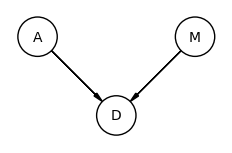

In [19]:
nodes = ["A", "D", "M"]
edges = [("A", "D"), ("M", "D")]
dag3 = CausalGraphicalModel(nodes=nodes, edges=edges)
pgm3 = PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in nodes:
    pgm3.add_node(node, node, *coordinates[node])
for edge in edges:
    pgm3.add_edge(*edge)
pgm3.render()
plt.gca().invert_yaxis()

Borramos el arco de $A \rightarrow M$, dado que si manipulamos $M$ entonces $A$ ya no lo influencia más. Es como un experimento perfectamente controlado.

Ahora, simulamos el cotnrafactual de manipular $M$, en un estado promedio $A = 0$.

- Variable de intervención y rango de valores.
- Usamos el modelo causal para simular valores de otras variables, incluyendo el resultado.

In [20]:
# Valores para la tasa de matrimonio
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fijamos la edad a cero (edad promedio)
age_shared.set_value(np.zeros(50))

# Simulamos
with multivariate_model_2:
    pp_samples_marriage = pm.sample_posterior_predictive(idata_multivariate_2)

Sampling: [divorce_rate_std, marriage_rate_std]


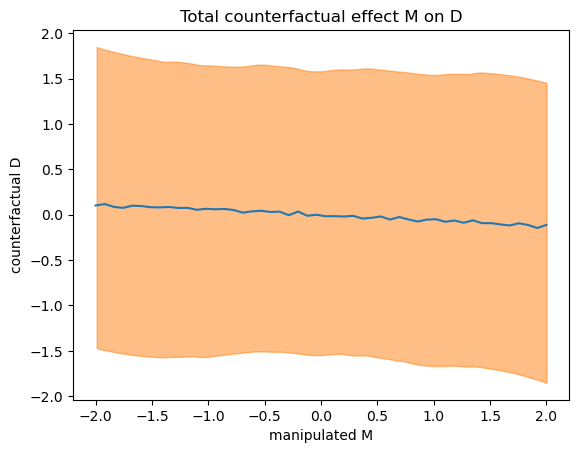

In [21]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, pp_samples_marriage.posterior_predictive["divorce_rate_std"], ax=ax)
ax.plot(
    marriage_counter_factual_x,
    pp_samples_marriage.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");